ref: https://github.com/prcastro/pytorch-gan/blob/master/MNIST%20GAN.ipynb

In [9]:
import itertools
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
from IPython import display

%matplotlib inline

In [10]:
batch_size = 32

In [27]:
# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=batch_size, 
                                           shuffle=True)

0it [00:00, ?it/s]

 99%|█████████▊| 9764864/9912422 [00:10<00:00, 2315227.72it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



0it [00:00, ?it/s]


  0%|          | 0/28881 [00:00<?, ?it/s]
32768it [00:00, 50814.11it/s]                           

0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



 63%|██████▎   | 1032192/1648877 [00:01<00:01, 364168.99it/s]
1654784it [00:02, 771793.67it/s]                             

0it [00:00, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



8192it [00:00, 20056.70it/s]            

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!



9920512it [00:30, 2315227.72it/s]                             

In [28]:
# download and transform test dataset
test_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [13]:
inputs, classes = next(iter(train_loader))

In [14]:
inputs.size()

torch.Size([32, 1, 28, 28])

In [15]:
classes.size()

torch.Size([32])

## GAN

### Hyper-paramters

In [16]:
num_epochs = 100
num_batches = len(train_loader)
d_steps = 1
g_steps = 1
learning_rate = 2e-4

In [17]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Linear(128, 256, bias=True)
        self.layer2 = nn.Linear(256, 784, bias=True)
        
    def forward(self, z):
        # z: noise
        h1 = F.relu(self.layer1(z))
        out = F.tanh(self.layer2(h1))
        return out

In [18]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Linear(784, 256, bias=True)
        self.layer2 = nn.Linear(256, 1, bias=True)
        
    def forward(self, x):
        # x: generated or real image (10, 1, 28, 28)
        x = x.view(x.size(0), -1) # (10, 784)
        h1 = F.relu(self.layer1(x))
        y = F.sigmoid(self.layer2(h1)) # (10, 1) -> probability
        return y.view(y.size(0))

In [19]:
G = Generator()
D = Discriminator()

In [20]:
# Binary Cross Entropy Loss(h(x), y), Sigmoid Cross Entropy Loss 함수라고도 불림. -ylogh(x)-(1-y)log(1-h(x))
criterion = nn.BCELoss() 

In [21]:
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(G.parameters(), lr=learning_rate)

In [22]:
use_cuda = torch.cuda.is_available()

In [23]:
if use_cuda:
    G = G.cuda()
    D = D.cuda()
    criterion = criterion.cuda()

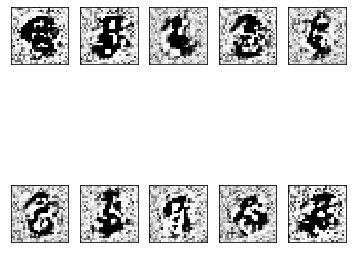

Epoch: 100/100, Step: 1500/1875, d_loss: 0.0002, g_loss: 10.9128


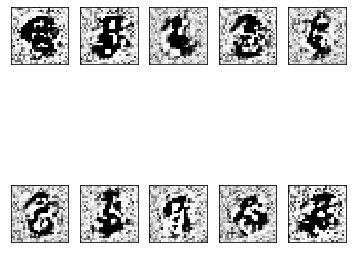

In [26]:
test_noise = torch.randn(batch_size, 128).cuda()

# create figure for plotting
row_num = 2
col_num = 5
fig, ax = plt.subplots(row_num, col_num, figsize=(6,6))
for i, j in itertools.product(range(row_num), range(col_num)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)


for epoch in range(num_epochs):
    for t, data in enumerate(train_loader, 0):
        x, _ = data # 10, 1, 28, 28 // 10
        x = x.cuda()
        x_labels = torch.ones(batch_size).cuda()
        z, z_labels = torch.randn(batch_size, 128).cuda(), torch.zeros(batch_size).cuda()
        
        # train Dis
        for d_idx in range(d_steps):
            d_optimizer.zero_grad()

            # train on real
            d_real_loss = criterion(D(x), x_labels)

            # train on fake
            d_fake_loss = criterion(D(G(z)), z_labels)
            
            d_loss = d_real_loss + d_fake_loss # criterion(D(x), 1) + criterion(D(G(z)), 0)
            d_loss.backward()
            d_optimizer.step()

        # train Gen
        for g_idx in range(g_steps):
            g_optimizer.zero_grad()
            z, z_labels = torch.randn(batch_size, 128).cuda(), torch.ones(batch_size).cuda()
            g_loss = criterion(D(G(z)), z_labels) # criterion(D(G(z)), 1)
            g_loss.backward()
            g_optimizer.step()
        
        # print status
        if (t+1) % 500 == 0:
            test_images = G(test_noise)
            
            for k in range(row_num*col_num):
                i = k//5
                j = k%5
                ax[i,j].cla() # clear the current axis
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28,28), cmap='Greys')
            
            display.clear_output(wait=True)
            display.display(plt.gcf()) # get a reference to a current figure
            
            print("Epoch: {}/{}, Step: {}/{}, d_loss: {:.4f}, g_loss: {:.4f}"
                  .format(epoch + 1, num_epochs, t+1, num_batches, d_loss.data.item(), g_loss.data.item()))